In [1]:
import numpy as np
import pandas as pd
import time
import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from boris_util import *

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Exploring the Dataset

First thing's first, let's load the dataset. I created a new function that loads up the dataset for me and converts it into a pandas dataframe for easy access. For more information on this, please see the `Data Cleaning` notebook

In [3]:
dataset = read_and_combine_data('453_923_bundle_archive', read_noisy_data=False)
print()
print(dataset.shape)
dataset.head()

processed 100.00%

(436, 3)


,signal,sampling_rate,label
0,"[2.2960085e-05, -0.00012982322, -0.00018070513...",22050,artifact
1,"[-1.0927635e-05, 1.0574424e-06, 2.108567e-06, ...",22050,artifact
2,"[3.728857e-05, -0.0001664555, -7.4023155e-05, ...",22050,artifact
3,"[-0.0027429417, -0.0066496185, -0.0049779303, ...",22050,artifact
4,"[0.000106223946, 0.0015002153, 0.0097254915, 0...",22050,artifact


Let's take a look at the class distribution to see if there is any concern of class imbalance

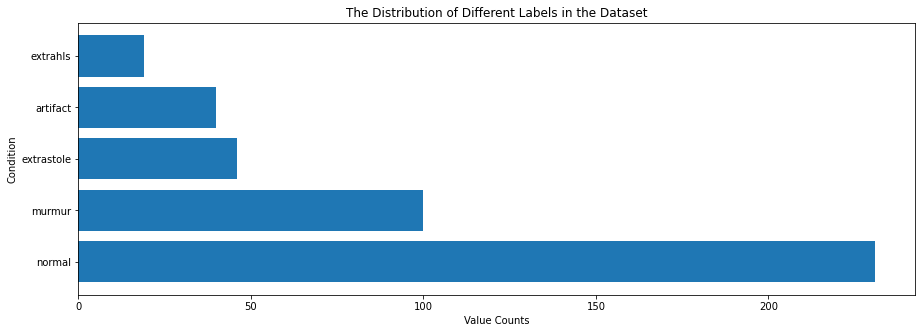

In [4]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Dataset")
plt.show()

There is certainly an issue of class imbalance here. A naive classifier could guess pretty well by simply guessing "Normal" on all the examples

## Combine all Abnormalities

Let's try a simple example first, we will combine all abnormalities into a single label "abnormal". We won't count artifacts in that category

In [11]:
def relabel(label):
    if (label == "normal"):
        return "normal"
    else:
        return "abnormal"
dataset['label'] = dataset['label'].apply(relabel)

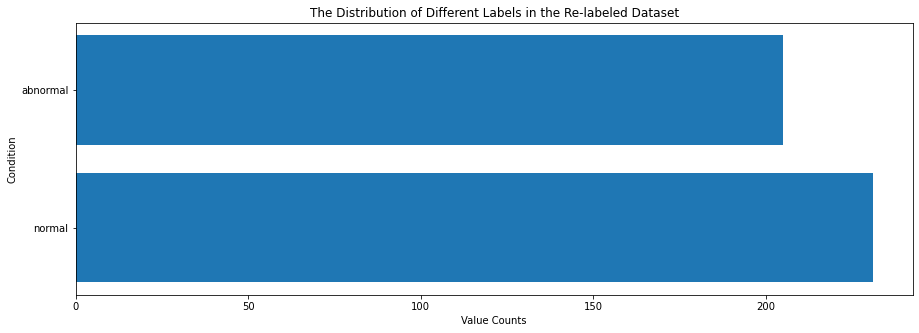

In [12]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Re-labeled Dataset")
plt.show()

Let's split our data now into a simple train/test stratified split

In [13]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, stratify=dataset['label'], random_state=1)
print(train_dataset.shape)
print(test_dataset.shape)

(305, 3)
(131, 3)


In [14]:
train_dataset.head()

,signal,sampling_rate,label
302,"[-0.014594975, -0.016623363, -0.017930867, -0....",22050,normal
401,"[0.00535502, 0.0048318487, 0.0038144102, 0.002...",22050,normal
311,"[-0.0009814408, -0.00052338943, 9.0988244e-05,...",22050,normal
346,"[-0.007578952, -0.011004641, -0.015165693, -0....",22050,normal
410,"[-0.030912954, -0.033952978, -0.035377894, -0....",22050,normal


## Dataset Augmentation

We won't get very far with the examples we have. There aren't very many of them

Luckily, we can easily augment the dataset by shifting the data and/or adding some noise

In [15]:
DATASET_TARGET = 1000

In [16]:
# find the label ratios
inverse_counts = 1/train_dataset['label'].value_counts()
probability_counts = inverse_counts/inverse_counts.sum()
probability_counts

normal      0.468852
abnormal    0.531148
Name: label, dtype: float64

In [17]:
#https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6
    
def shift_sound(data, sampling_rate, shift_max, shift_direction='right'):
    shift = np.random.randint(int(shift_max * data.shape[0]))
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data = augmented_data[shift:]
    else:
        augmented_data = augmented_data[:shift]
    return augmented_data

In [18]:
choices = np.random.choice(probability_counts.index, 
                           p=probability_counts.values, 
                           size=(DATASET_TARGET,))
i = 0
while train_dataset.shape[0] < DATASET_TARGET:
    choice = choices[i]
    available_instances = train_dataset[train_dataset['label'] == choice]
    selected_row_position = np.random.randint(available_instances.shape[0])
    
    selected_row = available_instances.iloc[selected_row_position]
    
    base_signal = selected_row['signal']
    sampling_rate = selected_row['sampling_rate']
    
    shift_direction = 'both'
    new_signal = shift_sound(base_signal, sampling_rate, (np.random.random()*0.3), shift_direction)
    if (new_signal.shape[0] > 0):
    
        new_series = pd.Series({'signal' :new_signal, 'sampling_rate': sampling_rate, 'label': choice})
        train_dataset = train_dataset.append(new_series, ignore_index=True)
    
        print(train_dataset.shape, end="\r")
    i+= 1

Now let's define a class which will convert the signals into Mel spectrograms

In [27]:
class MelEncoder:
    
    def __init__(self, flatten=True, n_fft=2048, hop_length=512, n_mels=128, sampling_rate=22050.0, n_windows=1000, verbose=0):
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sampling_rate = sampling_rate
        self.n_windows = n_windows
        self.verbose = verbose
        
        
        self.flatten = flatten
        
    
    def fit(self, X, y=None):
        self.longest_signal = None
        
    
    def transform(self, X):
        X_list = []
        
        
        for i, signal in enumerate(X):
            try:
                mel_spectrogram = self._signal_to_mel_spectrogram(signal)
                X_list.append(mel_spectrogram)
                if (self.verbose):
                    print(f"{round(100*i/X.shape[0], 2)}%")
            except ValueError as e:
                print(signal)
                print(signal.shape)
                plt.figure()
                plt.plot(signal)
                plt.show()
                raise e
            
            
        if (self.longest_signal is None):
            max_length = 0
            for mel_spectrogram in X_list:
                if (mel_spectrogram.shape[1] > max_length):
                    max_length = mel_spectrogram.shape[1]
                    
            self.longest_signal = max_length
        else:
            max_length = self.longest_signal
                
        X_transformed = np.zeros((len(X_list), self.n_mels, max_length))
        
        for i, mel_spectrogram in enumerate(X_list):
            if (mel_spectrogram.shape[1] <= max_length):
                X_transformed[i, :, -mel_spectrogram.shape[1]:] = mel_spectrogram[:, :]
            else:
                X_transformed[i, :, :] = mel_spectrogram[:, -max_length:]
            
            
            
            
        
        #X_transformed = np.array(X_list)
        
        
        
        if (self.flatten):
            return X_transformed.reshape(X_transformed.shape[0], -1)
        else:
            return X_transformed
        
        
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
        
        
        
        
    # https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
    def _longest_signal(self, signals):
        max_length = 0
        for signal in signals:
            if (len(signal) > max_length):
                max_length = len(signal)

        return max_length
    
    
    def _signal_to_mel_spectrogram(self, signal):
        
        
        if (self.n_windows is not None):
            hop_length = signal.shape[0]//self.n_windows
        else:
            hop_length = self.hop_length
        S = librosa.feature.melspectrogram(signal, 
                                           sr=self.sampling_rate, 
                                           n_fft=self.n_fft, 
                                           hop_length=hop_length, 
                                           n_mels=self.n_mels)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return S_DB

In [28]:
my_encoder = MelEncoder(n_mels=128, n_windows=1000)

In [29]:
my_encoder.fit(train_dataset['signal'])

In [30]:
X_train_mel = my_encoder.transform(train_dataset['signal'])

In [31]:
X_train_mel.shape

(1000, 134400)

In [32]:
X_test_mel = my_encoder.transform(test_dataset['signal'])

In [33]:
X_test_mel.shape

(131, 134400)

## PCA

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [35]:
my_mmscaler = MinMaxScaler()

X_train_mel = my_mmscaler.fit_transform(X_train_mel)
X_test_mel = my_mmscaler.transform(X_test_mel)

In [36]:
X_train_mel = X_train_mel
X_train_mel.shape

(1000, 134400)

In [37]:
%%time 

component_number = min(*X_train_mel.shape)
my_pca = PCA(n_components=component_number, svd_solver='randomized')
my_pca.fit(X_train_mel)

Wall time: 2min 44s


PCA(n_components=1000, svd_solver='randomized')

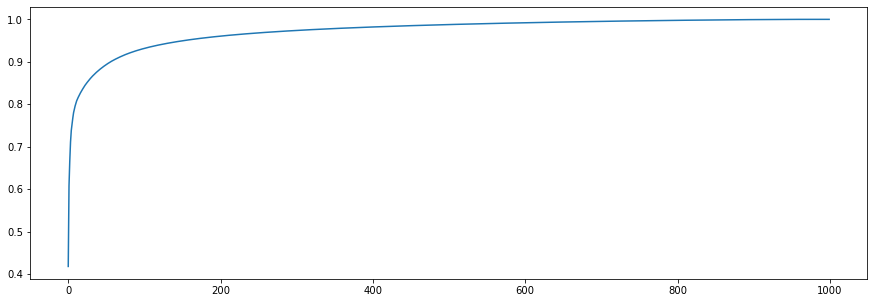

In [38]:
plt.figure(figsize=(15,5))
plt.plot(my_pca.explained_variance_ratio_.cumsum())
plt.show()

In [39]:
X_train_mel = my_pca.transform(X_train_mel)
X_test_mel = my_pca.transform(X_test_mel)

In [40]:
X_train_mel.shape

(1000, 1000)

In [41]:
X_test_mel.shape

(131, 1000)

## Basic Model - Logistic Regression

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [42]:
condition_label_encoder = LabelEncoder()


y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(1000, 1000) (131, 1000)
(1000,) (131,)


In [43]:
%%time

my_logit = LogisticRegression(random_state=1).fit(X_train_mel, y_train)
train_acc = my_logit.score(X_train_mel, y_train)
test_acc = my_logit.score(X_test_mel, y_test)

Wall time: 1.11 s


In [44]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 100.0%
The test accuracy is 60.31%


Extremely suspicious results. There is clearly a very large sign of overfitting here. Let's explore how the logistic regression makes decisions.

Let's plot the coefficients as if they were an audio mask (which is really what they end up becoming).

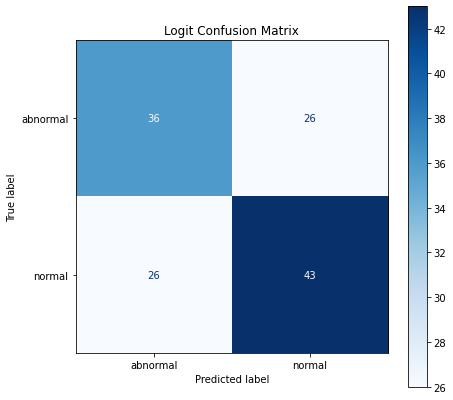

In [46]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

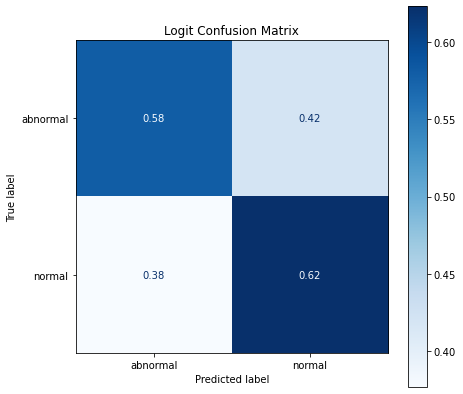

In [47]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [58]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [10**i for i in range(-7, 8)]}
my_estimator = LogisticRegression(solver='saga')
my_gs = GridSearchCV(my_estimator, param_grid, cv=5, verbose=2)

In [59]:
%%time
my_gs.fit(X_train_mel, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] C=1e-07, penalty=l1 .............................................
[CV] .............................. C=1e-07, penalty=l1, total=   0.0s
[CV] C=1e-07, penalty=l1 .............................................
[CV] .............................. C=1e-07, penalty=l1, total=   0.0s
[CV] C=1e-07, penalty=l1 .............................................
[CV] .............................. C=1e-07, penalty=l1, total=   0.0s
[CV] C=1e-07, penalty=l1 .............................................
[CV] .............................. C=1e-07, penalty=l1, total=   0.0s
[CV] C=1e-07, penalty=l1 .............................................
[CV] .............................. C=1e-07, penalty=l1, total=   0.0s
[CV] C=1e-07, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............................. C=1e-07, penalty=l2, total=   0.8s
[CV] C=1e-07, penalty=l2 .............................................
[CV] .............................. C=1e-07, penalty=l2, total=   0.7s
[CV] C=1e-07, penalty=l2 .............................................
[CV] .............................. C=1e-07, penalty=l2, total=   0.7s
[CV] C=1e-07, penalty=l2 .............................................
[CV] .............................. C=1e-07, penalty=l2, total=   0.8s
[CV] C=1e-07, penalty=l2 .............................................
[CV] .............................. C=1e-07, penalty=l2, total=   0.7s
[CV] C=1e-06, penalty=l1 .............................................
[CV] .............................. C=1e-06, penalty=l1, total=   0.0s
[CV] C=1e-06, penalty=l1 .............................................
[CV] .............................. C=1e-06, penalty=l1, total=   0.0s
[CV] C=1e-06, penalty=l1 .............................................
[CV] .

[CV] ................................ C=0.1, penalty=l1, total=   1.1s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   1.0s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   0.8s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   0.8s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   0.8s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   0.8s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=   0.8s
[CV] C=1, penalty=l1 .................................................
[CV] .

[CV] ............................. C=100000, penalty=l1, total=   1.8s
[CV] C=100000, penalty=l1 ............................................
[CV] ............................. C=100000, penalty=l1, total=   1.8s
[CV] C=100000, penalty=l1 ............................................
[CV] ............................. C=100000, penalty=l1, total=   1.8s
[CV] C=100000, penalty=l1 ............................................
[CV] ............................. C=100000, penalty=l1, total=   1.8s
[CV] C=100000, penalty=l2 ............................................
[CV] ............................. C=100000, penalty=l2, total=   0.8s
[CV] C=100000, penalty=l2 ............................................
[CV] ............................. C=100000, penalty=l2, total=   0.8s
[CV] C=100000, penalty=l2 ............................................
[CV] ............................. C=100000, penalty=l2, total=   0.9s
[CV] C=100000, penalty=l2 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.3min finished


Wall time: 2min 17s


GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                               10, 100, 1000, 10000, 100000, 1000000,
                               10000000],
                         'penalty': ['l1', 'l2']},
             verbose=2)

In [60]:
my_gs.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [62]:
my_gs.score(X_test_mel, y_test)

0.6106870229007634

In [63]:
train_acc = my_gs.score(X_train_mel, y_train)
test_acc = my_gs.score(X_test_mel, y_test)

In [64]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 86.2%
The test accuracy is 61.07%


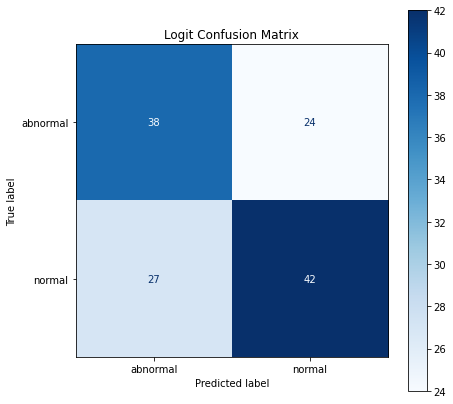

In [65]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

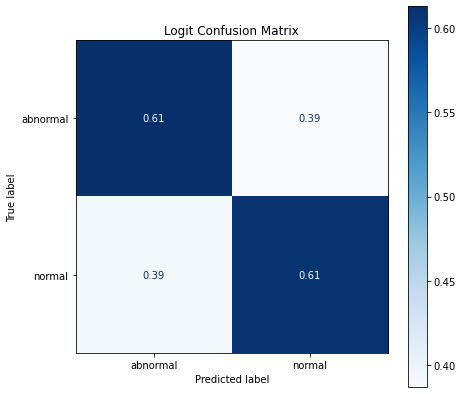

In [66]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [67]:
print(classification_report(y_test, my_gs.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.58      0.61      0.60        62
           1       0.64      0.61      0.62        69

    accuracy                           0.61       131
   macro avg       0.61      0.61      0.61       131
weighted avg       0.61      0.61      0.61       131



## Basic Model - Decision Tree

As another baseline, I will train a decision tree to see if introducing non-linearity to the learning process produces better results

In [68]:
print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(1000, 1000) (131, 1000)
(1000,) (131,)


In [84]:
%%time 

# Let's set some regularization otherwise we know the tree will overfit
my_tree = DecisionTreeClassifier()
param_grid = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)]}

my_tree_gs = GridSearchCV(my_tree, param_grid, cv=5, verbose=1, n_jobs=3)
my_tree_gs.fit(X_train_mel, y_train)


train_acc = my_tree_gs.score(X_train_mel, y_train)
test_acc = my_tree_gs.score(X_test_mel, y_test)

Fitting 5 folds for each of 1045 candidates, totalling 5225 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 145 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done 743 tasks      | elapsed:   25.9s
[Parallel(n_jobs=3)]: Done 993 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 1343 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 1793 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 2499 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 3149 tasks      | elapsed:  4.8min
[Parallel(n_jobs=3)]: Done 4117 tasks      | elapsed:  6.6min
[Parallel(n_jobs=3)]: Done 5010 tasks      | elapsed:  8.3min
[Parallel(n_jobs=3)]: Done 5225 out of 5225 | elapsed:  8.8min finished


Wall time: 8min 50s


In [85]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 88.5%
The test accuracy is 51.15%


In [86]:
my_tree_gs.best_params_

{'max_depth': 901, 'max_features': 0.6, 'min_samples_leaf': 10}

Much better results! However, let's see how the model performs using the confusion matrix of the test set



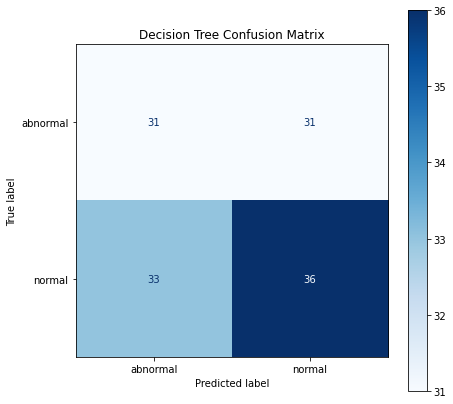

In [87]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_tree_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

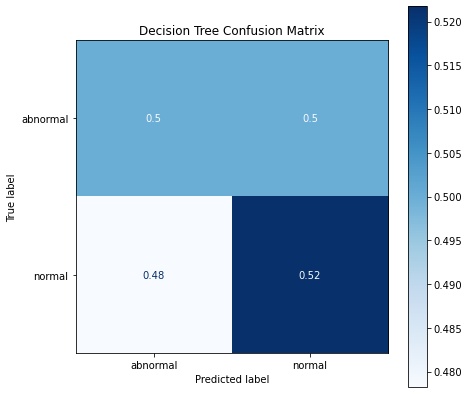

In [88]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_tree_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Decision Tree Confusion Matrix")
plt.show()

As suspected, quite a bit of the classification seems to classify abnormal conditions and sounds as "normal" due to the sheer volume of that class, but interestingly, ~39% of the normal examples get misclassified as abnormalities.

In [89]:
print(classification_report(y_test, my_gs.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.58      0.61      0.60        62
           1       0.64      0.61      0.62        69

    accuracy                           0.61       131
   macro avg       0.61      0.61      0.61       131
weighted avg       0.61      0.61      0.61       131



## Advanced Model - Random Forest

...

In [91]:
print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(1000, 1000) (131, 1000)
(1000,) (131,)


In [99]:
%%time 

# Let's set some regularization otherwise we know the tree will overfit
my_gb = RandomForestClassifier(min_samples_leaf=10, 
                               max_features=0.6,
                               max_depth=901,
                               random_state=1, 
                               n_estimators=350,
                               verbose=1,
                               n_jobs=3).fit(X_train_mel, y_train)


train_acc = my_gb.score(X_train_mel, y_train)
test_acc = my_gb.score(X_test_mel, y_test)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   33.9s
[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:  1.0min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s


Wall time: 1min 1s


[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:    0.0s finished


In [100]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 98.7%
The test accuracy is 68.7%


Much better results! However, let's see how the model performs using the confusion matrix of the test set



[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:    0.0s finished


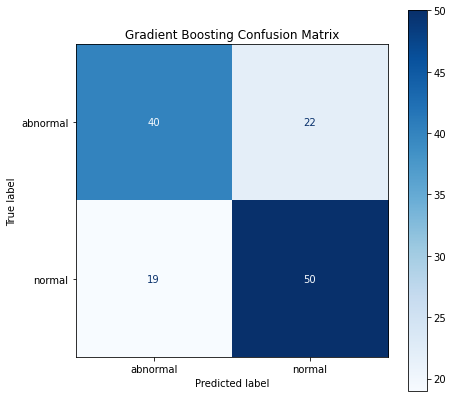

In [101]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_gb, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Gradient Boosting Confusion Matrix")
plt.show()

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:    0.0s finished


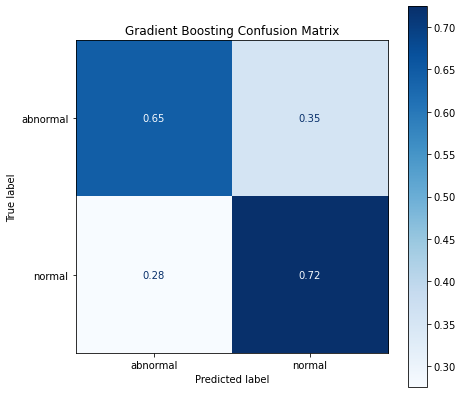

In [102]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_gb, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             ax=ax)
disp.ax_.set_title("Gradient Boosting Confusion Matrix")
plt.show()

In [103]:
print(classification_report(y_test, my_gb.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.68      0.65      0.66        62
           1       0.69      0.72      0.71        69

    accuracy                           0.69       131
   macro avg       0.69      0.68      0.69       131
weighted avg       0.69      0.69      0.69       131



[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:    0.0s finished


## Convolutional Neural Network

In [ ]:
my_encoder = MelEncoder(flatten=False)

In [ ]:
my_encoder.fit(train_dataset['signal'])

In [ ]:
X_train_mel = my_encoder.transform(train_dataset['signal'])
#X_train_mel = np.expand_dims(X_train_mel, axis=-1)

In [ ]:
X_train_min = X_train_mel.min()
print(X_train_min)
X_train_mel /= np.abs(X_train_min)
X_train_mel.shape

In [ ]:
X_test_mel = my_encoder.transform(test_dataset['signal'])
#X_test_mel = np.expand_dims(X_test_mel, axis=-1)
X_test_mel /= np.abs(X_train_min)

In [ ]:
X_test_mel.shape

In [ ]:
condition_label_encoder = LabelEncoder()


y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D, LSTM
from tensorflow.keras.optimizers import Adam


In [ ]:
my_model = Sequential()

In [ ]:
my_model.add(LSTM(25, activation="relu", input_shape = X_train_mel.shape[1:], return_sequences=True))
my_model.add(Dropout(0.2))
my_model.add(BatchNormalization())

my_model.add(LSTM(25, activation="relu", return_sequences=True))
my_model.add(Dropout(0.2))
my_model.add(BatchNormalization())

my_model.add(LSTM(25, activation="relu"))
my_model.add(Dropout(0.2))
my_model.add(BatchNormalization())

my_model.add(Dense(13, activation="relu"))
my_model.add(Dropout(0.2))
my_model.add(BatchNormalization())

my_model.add(Dense(3, activation="softmax"))

In [ ]:
my_model.summary()

In [ ]:
# Compile the model with the desired loss function, optimizer, and metric to optimize
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [ ]:
my_model.fit(X_train_mel, y_train,
              batch_size = 12,
              epochs = 10,
              verbose = 1,
              validation_data=(X_test_mel, y_test))

In [ ]:
my_model.add(Conv2D(13, activation="relu", kernel_size=(3,3), input_shape = X_train_mel.shape[1:]))
my_model.add(Dropout(0.2))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D())

my_model.add(Conv2D(12, activation="relu", kernel_size=(3,3)))
my_model.add(Dropout(0.2))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D())

my_model.add(Conv2D(12, activation="relu", kernel_size=(3,3)))
my_model.add(Dropout(0.2))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D())

my_model.add(Flatten())

my_model.add(Dense(13, activation="relu"))
my_model.add(Dropout(0.2))
my_model.add(BatchNormalization())

my_model.add(Dense(3, activation="softmax"))

In [ ]:
my_model.summary()

In [ ]:
# Compile the model with the desired loss function, optimizer, and metric to optimize
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [ ]:
my_model.fit(X_train_mel, y_train,
              batch_size = 12,
              epochs = 10,
              verbose = 1,
              validation_data=(X_test_mel, y_test))

In [ ]:
# Evaluate the model's performance on the test data
score = my_model.evaluate(X_test_mel, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
y_test

In [ ]:
my_model.predict(X_test_mel)